# Кластерный анализ

#### 1. Кластеризация на основе прототипов
Кластеризация на основе прототипов означает, что каждый кластер представляется прототипом, который обычно будет либо центроидом (средним) подобных точек с непрерывными признаками, либо медиодом (наиболее репрезентативной точкой или точкой, сводящей к минимуму расстояние до всех остальных точек, которые принадлежат кластеру).

K-means - хорош в идентификации кластеров со сферической формой, но недостаток в том, что необходимо заранее указывать количество кластеров в данных. 

K-means:
1) Случайным образом выбрать k центроидов из образцов в качестве начальных центров кластеров. 
2) Назначить каждый образец ближайшему центроиду.
3) Переместить каждый центроид в центр образцов, которые ему были назначены. 
4) Повторять шаги 2 и 3 до тех пор, пока назначения кластеров не перестанут изменяться или не будет достигнуто максимальное количество итераций. 

1. Подготовка искусственного набора данных:

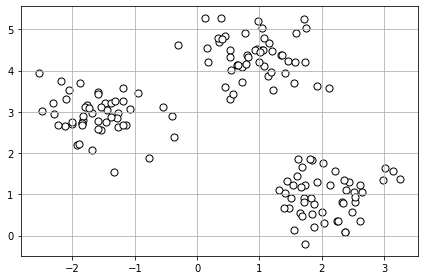

In [1]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=0.5,
                  shuffle=True,
                  random_state=0)

import matplotlib.pyplot as plt
plt.scatter(X[:, 0],
            X[:, 1],
            c='white',
            marker='o',
            edgecolors='black',
            s=50)
plt.grid()
plt.tight_layout()
plt.show()

2. Kmeans

In [2]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,
            init='random',
            n_init=10,  # 10 раз выполнить кластеризацию с разными случайными центрами
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

3. Визуализация:

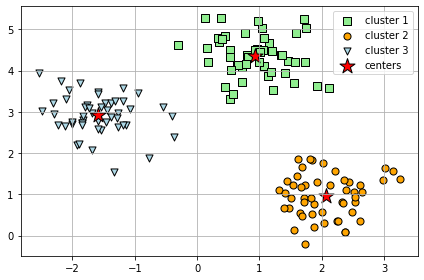

In [3]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')

plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')

plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='cluster 3')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolors='black',
            label='centers')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Другая стратегия предполагает размещение исходных центроидов далеко друг от друга посредством алгоритма K-Means++, который дает лучшие и более согласованные результаты, чем классический алгоритм K-Means.
1) Инициализировать пустой набор М для хранения выбираемых k центроидов. 
2) Случайным образом выбрать из входных образцов первый центроид и присвоить его М. 
3) Для каждого образца, отсутствующего в М, найти минимальное квадратичное расстояние до всех центроидов в М. 
4) Для случайного выбора следующего центроида использовать взвешенное распределение вероятностей вида $$\frac{d(µ^{(p)}, M)^2}{\sum d(x^{(i)}, M)^2}$$
5) Повторять шаги 2 и 3 до тех пор, пока не будет выбрано k центроидов. 
6) Продолжить выполнение согласно классическому алгоритму K-Means. 

#### Использование метода локтя для нахождения оптимального кол-ва кластеров 

Для количественной оценки качества кластеризации необходимо использовать внутренние метрики, такие как внутрикаластерное значение SSE (искажение), чтобы сравнить эффективность разных результатов кластеризации K-means.

In [4]:
print('Искажение: ', km.inertia_)

Искажение:  72.47601670996698


На основе внутрикластерного значения SSE мы можем воспользоваться графическим инструментом - так называемым методом локтя - для оценки оптимального количества кластеров k в имеющейся задаче. Мы можем сказать, что с увеличением k искажение будет понижаться. Причина в том, что образцы станут располагаться ближе к центроидам, которым они назначены. Идея метода локтя заключается в том, чтобы идентифицировать значение k, при котором искажение начинает увеличиваться быстрее всего, что прояснится, если построить график искажения для разных значений k: 

C:\Users\zekat\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


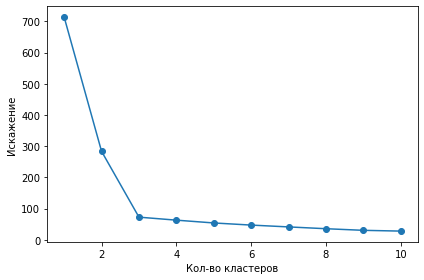

In [5]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Кол-во кластеров')
plt.ylabel('Искажение')
plt.tight_layout()
plt.show()

Как видно на результирующем графике, локоть находится в точке k = 3, свидетельствуя о том, что k = 3 - хороший выбор для этого набора данных.

#### Количественная оценка качества кластеризации через графики силуэтов

Еще одной внутренней метрикой для оценки качества кластеризации является анализ силуэтов, который может применяться также к рассматриваемым далее в главе алгоритмам кластеризации , отличающимся от K-Means.
Анализ силуэтов может использоваться как графический инструмент для построения графика, который отображает меру плотности группирования образцов в кластерах.
1) Вычислить связность кластера $a^{(i)}$ как среднее расстояние между образцом $x^{(i)}$ и всеми остальными точками в том же самом кластере. 
2) Вычислить отделение кластера $b^{(i)}$ от следующего ближайшего кластера как среднее расстояние между образцом $x^{(i)}$ и всеми образцами в ближайшем кластере. 
3) Вычислить силуэт $s^{(i)}$ как разность между связностью и отделением кластера, деленную на большее среди них значение:
$$s^{(i)}=\frac{b^{(i)}-a^{(i)}}{max(b^{(i)}, a^{(i)})}$$

Коэффициент силуэта ограничен диапазоном от -1 до 1. Основываясь на предыдущем уравнении, мы можем отметить, что коэффициент силуэта равен О в случае равенства отделения и связности кластера ($b^{(i)}$ = $a^{(i)}$)). Кроме того, мы приближаемся к идеальному коэффициенту силуэта, если $b^{(i)}$ >> $a^{(i)}$>, т.к. $b^{(i)}$ количественно определяет, насколько образец не похож на образцы
из других кластеров, и $a^{(i)}$ сообщает о том, в какой степени он похож на остальные образцы в своем кластере. 

In [6]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

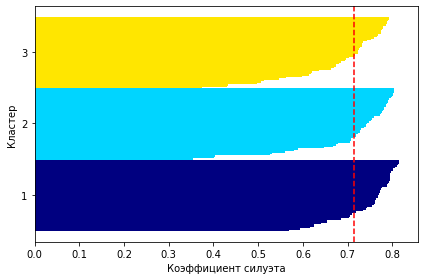

In [7]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X,
                                     y_km,
                                     metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
ytricks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    ytricks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(ytricks, cluster_labels + 1)
plt.ylabel('Кластер')
plt.xlabel('Коэффициент силуэта')
plt.tight_layout()
plt.show()

Коэффициенты силуэта далеки от 0, что в данном случае является индикатором хорошей кластеризации. Средний коэффициент силуэта изображен пунктирной линией.

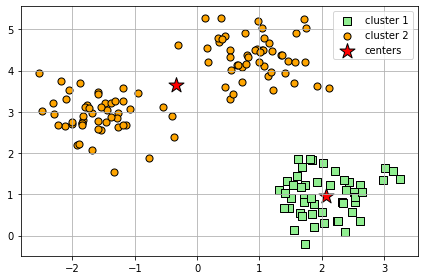

In [8]:
km = KMeans(n_clusters=2,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='cluster 1')

plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='cluster 2')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolors='black',
            label='centers')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

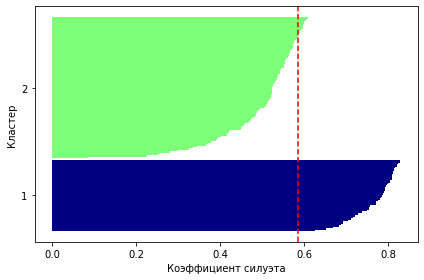

In [9]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X,
                                     y_km,
                                     metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
ytricks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    ytricks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(ytricks, cluster_labels + 1)
plt.ylabel('Кластер')
plt.xlabel('Коэффициент силуэта')
plt.tight_layout()
plt.show()

На полученном графике коэффициентов силуэта видно , что теперь силуэты заметно отличаются по длине и ширине, что подтверждает относительно плохую или, во всяком случае, субоптимальную кластеризацию.

#### 2. Иерархическая кластеризация
Преимущества:
1. Позволяют строить дендрограммы (древовидные диаграммы с визуализацией двоичной иерархической кластеризации), которые могут помочь с интерпретацией результатов за счет содержательной систематизации.
2. Не нужно указывать кол-во кластеров.

Существуют два основных подхода к иерархической кластеризации - агломеративиый (противоположен дивизному) и дивизый (начинаем с одного кластера и итеративно разделяем его на меньшие кластеры, пока они не будут содержать по одному образцу). 

Есть два стандартных алгоритма для агломеративной иерархической кластеризации - метод одииочной связи и метод полиой связи. С применением метода одиночной связи мы вычисляем расстояния между наиболее похожими членами для каждой пары кластеров и объединяем два кластера с наименьшим расстоянием между самыми похожими членами. Метод полной связи аналогичен методу одиночной связи, но вместо сравнения наиболее похожих членов в каждой паре кластеров для выполнения объединения мы сравниваем самые непохожие члены.

Метод полной связи:
1. Рассчитать матрицу расстояний для всех образцов.
2. Представить каждую точку данных как одноэлементный кластер.
3. Объединить два ближайших кластера, основываясь на расстоянии между самыми непохожими (дальними) членами.
4. Обновить матрицу подобия.
5. Повторять шаги 2-4 до тех пор, пока не останется единственный кластер. 

In [16]:
# генерация случайных данных
import pandas as pd
import numpy as np

np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample((5, 3))*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


1) Рассчитать матрицу расстояний

In [32]:
np.sqrt((df.iloc[0, 0] - df.iloc[1, 0])**2 + (df.iloc[0, 1] - df.iloc[1, 1])**2 +
        (df.iloc[0, 2] - df.iloc[1, 2])**2)

4.973534001694992

In [17]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(
                        pdist(df, metric='euclidean')),
                        columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


2) Применяем к кластерам метод полной связи

!!! linkage принимает сжатую матрицу расстояний (из pdist) !!!

In [35]:
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(pdist(df, metric='euclidean'),
                       method='complete')
row_clusters

array([[0.        , 4.        , 3.83539555, 2.        ],
       [1.        , 2.        , 4.34707339, 2.        ],
       [3.        , 5.        , 5.89988504, 3.        ],
       [6.        , 7.        , 8.31659367, 5.        ]])

In [40]:
pd.DataFrame(row_clusters,
             columns=['Метка строки 1',
                      'Метка строки 2',
                      'Расстояние',
                      'Кол-во элементов в кластере'],
            index=[f'Кластер {i+1}' for i in range(row_clusters.shape[0])])

,Метка строки 1,Метка строки 2,Расстояние,Кол-во элементов в кластере
Кластер 1,0.0,4.0,3.835396,2.0
Кластер 2,1.0,2.0,4.347073,2.0
Кластер 3,3.0,5.0,5.899885,3.0
Кластер 4,6.0,7.0,8.316594,5.0


Первый и второй столбцы отмечают самые непохожие члены в каждом кластере, а третий столбец указывает расстояние между этими членами. В последнем столбце приводится
количество членов в каждом кластере. 

Визуализация результата в форме дендограммы:

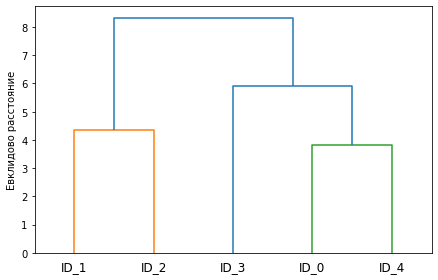

In [41]:
from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters,
                       labels=labels)
plt.tight_layout()
plt.ylabel('Евклидово расстояние')
plt.show()

Дендрограмма такого рода подытоживает различные кластеры, которые
были сформированы во время агломеративной иерархической кластеризации; скажем, мы видим, что на основе метрики евклидова расстояния наиболее похожими оказываются образцы ID_О и ID_4, за которыми следуют
образцы ID_1 и ID_2. 

Прикрепление дендограмм к тепловой карте:

1) Мы создаем новый объект figure и определяем позицию оси х, позицию оси у, ширину и высоту дендрограммы через атрибут add_axes. Вдобавок мы поворачиваем дендрограмму на 90 градусов против часовой стрелки:

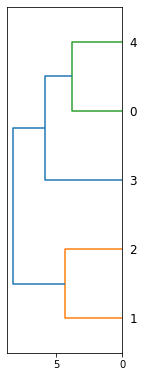

In [49]:
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')

2) Затем посредством ключа leaves мы переупорядочиваем данные в первоначальном объекте DataFrame согласно меткам кластеров, доступ к которым можно получать из объекта дендрограммы, по существу представляющего собой словарь Python:

In [46]:
row_dendr['leaves']

[1, 2, 3, 0, 4]

In [50]:
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]
df_rowclust

,X,Y,Z
ID_4,4.385722,0.596779,3.980443
ID_0,6.964692,2.861393,2.268515
ID_3,3.921175,3.431780,7.290497
ID_2,9.807642,6.848297,4.809319
ID_1,5.513148,7.194690,4.231065


3) Теперь из переупорядоченного объекта DataFrame мы строим тепловую карту и размещаем ее рядом с дендрограммой: 

In [51]:
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust,
                  interpolation='nearest',
                  cmap='hot_r')

4) Улучшим эстетическое восприятие дендограммы, удалив отметки осей и скрыв их лини. Добавление цветовой полосы и назначение имен признаков и записей данных:

C:\Users\zekat\AppData\Local\Temp/ipykernel_5472/3432642296.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axm.set_xticklabels([''] + list(df_rowclust.columns))
C:\Users\zekat\AppData\Local\Temp/ipykernel_5472/3432642296.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  axm.set_yticklabels([''] + list(df_rowclust.index))


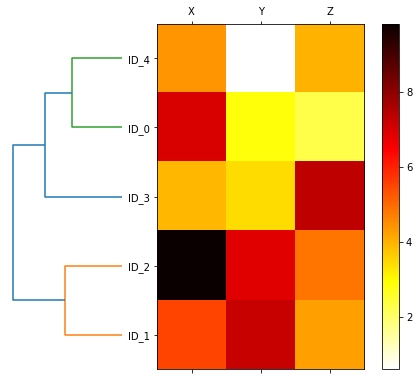

In [53]:
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust,
                  interpolation='nearest',
                  cmap='hot_r')

axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))
plt.show()

### Применение агломеративной иерархической кластеризации с помощью scikit-learn

Класс Agglomerati veClustering полезен, если мы хотим подрезать иерархическое дерево кластеров. Устанавливая параметр n_cluster в 3, мы
теперь кластеризируем образцы в три группы с применением того же самого метода полной связи, основанного на метрике евклидова расстояния:

In [54]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3,
                             affinity='euclidean',
                             linkage='complete')
labels = ac.fit_predict(X)
print('Метки классов: ', labels)

Метки классов:  [1 0 0 2 1]


In [55]:
ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
labels = ac.fit_predict(X)
print('Метки классов: ', labels)

Метки классов:  [0 1 1 0 0]


#### Нахождение областей высокой плотности с помощью DBSCAN 

Алгоритм кластеризации, основанный на плотности пространственной кластеризации для приложений с шумами. Подход DBSCAN не выдвигает допущений о сферических кластерах, как делает алгоритм K-Means, и не разделяет набор данных на иерархии, требующие указываемой вручную точки подрезания. Из самого названия следует, что кластеризация на базе плотности назначает метки кластеров, основываясь на плотных областях точек.
В DBSCAN понятие плотности определяется как количество точек внутри
указанного радиуса E.
Согласно алгоритму DBSCAN каждому образцу (точке данных) назначается специальная метка с применением перечисленных ниже критериев.
• Точка считается ядерной (core point), если, по крайней мере, указанное количество (MinPts) соседних точек попадают внутрь заданного радиуса E.
• Граничная точка (border point) - это точка, имеющая число соседей меньше MinPts в пределах E, но лежащая внутри радиуса E ядерной точки.
• Все остальные точки, которые не являются ядерными или граничными, трактуются как шумовые (noise point).

После пометки точек как ядерных, граничных или шумовых алгоритм
DBSCAN сводится к выполнению двух простых шагов.
1. Сформировать отдельный кластер для каждой ядерной точки или связной группы ядерных точек. (Ядерные точки считаются связными, если расположены не дальше чем E.)
2. Назначить каждую граничную точку кластеру, к которому принадлежит соответствующая ей ядерная точка. 

<img src="pic/dbscan.png" width="400" height="500"/>

Создание набора данных в форме полумесяца:

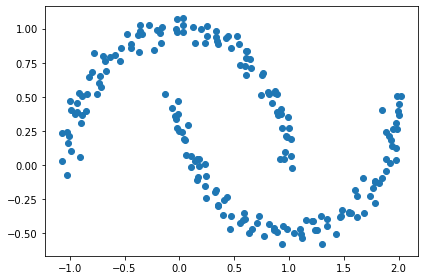

In [76]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200,
                  noise=0.05,
                  random_state=0)

plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
plt.show()

Кластеризация K-Means и агломеративная иерархическая кластеризация методом полной связи:

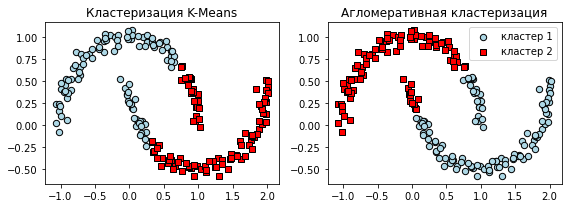

In [77]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2,
            random_state=0)
y_km = km.fit_predict(X)

ax1.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='кластер 1')
ax1.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            c='red',
            edgecolor='black',
            marker='s',
            s=40,
            label='кластер 2')
ax1.set_title('Кластеризация K-Means')

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)

ax2.scatter(X[y_ac == 0, 0],
            X[y_ac == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='кластер 1')
ax2.scatter(X[y_ac == 1, 0],
            X[y_ac == 1, 1],
            c='red',
            edgecolor='black',
            marker='s',
            s=40,
            label='кластер 2')
ax2.set_title('Агломеративная кластеризация')
plt.legend()
plt.tight_layout()
plt.show()

DBSCAN:

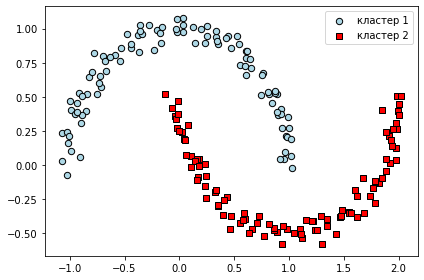

In [78]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2,
            min_samples=5,
            metric='euclidean')
y_db = db.fit_predict(X)

plt.scatter(X[y_db == 0, 0],
            X[y_db == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='кластер 1')
plt.scatter(X[y_db == 1, 0],
            X[y_db == 1, 1],
            c='red',
            edgecolor='black',
            marker='s',
            s=40,
            label='кластер 2')
plt.legend()
plt.tight_layout()
plt.show()

Недостатки алгоритма DBSCAN:
С увеличением количества признаков в наборе данных (при условии фиксированного числа обучающих образцов) растет отрицательное воздействие "проклятия размерности". Особенно остро проблема проявляется, когда используется метрика евклидова расстояния. Однако проблема "проклятия размерности" не уникальна для DBSCAN; она также оказывает влияние на другие алгоритмы кластеризации, в которых применяется
метрика евклидова расстояния, например, K-Means и алгоритмы иерархической кластеризации. Вдобавок в алгоритме DBSCAN есть два гиперпараметра (MinPts и е), которые нуждаются в оптимизации.

Таким образом, в контексте "проклятия размерности" устоявшаяся практика предусматривает применение приемов понижения размерности до выполнения самой кластеризации. Такие приемы понижения размерности для
непомеченных наборов данных включают анализ главных компонент с ядром RBF.

In [ ]:
454